# SAR Image Colorization - Data Exploration & Visualization

## Overview
This notebook provides comprehensive exploration and visualization of the SAR image colorization dataset. It includes:

- **Dataset Statistics**: Analysis of SAR, optical, and target RGB images
- **Image Distributions**: Intensity distributions and statistical properties
- **Visual Comparisons**: Side-by-side comparisons of SAR vs optical vs colorized images
- **Data Quality Assessment**: Anomaly detection and data validation
- **Augmentation Effects**: Visualization of data augmentation transformations


## Dataset Structure
```
Data/
├── Processed/
│   ├── train/
│   │   ├── SAR/          # SAR input images
│   │   └── Optical/      # Optical target images
│   └── val/
│       ├── SAR/          # Validation SAR images
│       └── Optical/      # Validation optical images
└── Raw/                  # Raw datasets (Sentinel-1, MSTAR, etc.)
```


In [2]:
# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(" Libraries imported successfully!")
print(f" Current working directory: {os.getcwd()}")
print(f" Python version: {sys.version}")


 Libraries imported successfully!
 Current working directory: d:\ColorWave\SAR_Image_Colorization\notebooks
 Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]


In [3]:
# Configuration
CONFIG = {
    'data_root': '../Data/Processed',
    'train_sar_path': '../Data/Processed/train/SAR',
    'train_optical_path': '../Data/Processed/train/Optical',
    'val_sar_path': '../Data/Processed/val/SAR',
    'val_optical_path': '../Data/Processed/val/Optical',
    'raw_data_path': '../Data/Raw',
    'sample_size': 100,  # Number of samples to analyze
    'image_size': (256, 256),  # Expected image dimensions
    'channels': {
        'sar': 1,      # Grayscale SAR images
        'optical': 3   # RGB optical images
    }
}

# Verify paths exist
for key, path in CONFIG.items():
    if 'path' in key and os.path.exists(path):
        print(f" {key}: {path}")
    elif 'path' in key:
        print(f" {key}: {path} (not found)")

print(f"\n Configuration loaded: {len(CONFIG)} parameters")

 train_sar_path: ../Data/Processed/train/SAR
 train_optical_path: ../Data/Processed/train/Optical
 val_sar_path: ../Data/Processed/val/SAR
 val_optical_path: ../Data/Processed/val/Optical
 raw_data_path: ../Data/Raw

 Configuration loaded: 9 parameters


In [4]:
# Dataset Statistics and File Analysis
def analyze_dataset_structure(data_path):
    """Analyze the structure and statistics of the dataset"""
    stats = {
        'total_files': 0,
        'file_types': {},
        'file_sizes': [],
        'dimensions': [],
        'corrupted_files': []
    }
    
    if not os.path.exists(data_path):
        print(f" Path does not exist: {data_path}")
        return stats
    
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                file_path = os.path.join(root, file)
                stats['total_files'] += 1
                
                # File type
                ext = file.split('.')[-1].lower()
                stats['file_types'][ext] = stats['file_types'].get(ext, 0) + 1
                
                # File size
                try:
                    size = os.path.getsize(file_path)
                    stats['file_sizes'].append(size)
                    
                    # Image dimensions
                    with Image.open(file_path) as img:
                        stats['dimensions'].append(img.size)
                        
                except Exception as e:
                    stats['corrupted_files'].append(file_path)
                    print(f" Corrupted file: {file_path} - {e}")
    
    return stats

# Analyze training data
print(" Analyzing dataset structure...")
train_stats = analyze_dataset_structure(CONFIG['train_sar_path'])
val_stats = analyze_dataset_structure(CONFIG['val_sar_path'])

print(f"\n Training Data Statistics:")
print(f"   Total files: {train_stats['total_files']}")
print(f"   File types: {train_stats['file_types']}")
print(f"   Average file size: {np.mean(train_stats['file_sizes'])/1024:.1f} KB")
print(f"   Corrupted files: {len(train_stats['corrupted_files'])}")

print(f"\n Validation Data Statistics:")
print(f"   Total files: {val_stats['total_files']}")
print(f"   File types: {val_stats['file_types']}")
print(f"   Average file size: {np.mean(val_stats['file_sizes'])/1024:.1f} KB")
print(f"   Corrupted files: {len(val_stats['corrupted_files'])}")


 Analyzing dataset structure...

 Training Data Statistics:
   Total files: 22
   File types: {'png': 22}
   Average file size: 64.4 KB
   Corrupted files: 0

 Validation Data Statistics:
   Total files: 7
   File types: {'png': 7}
   Average file size: 64.4 KB
   Corrupted files: 0


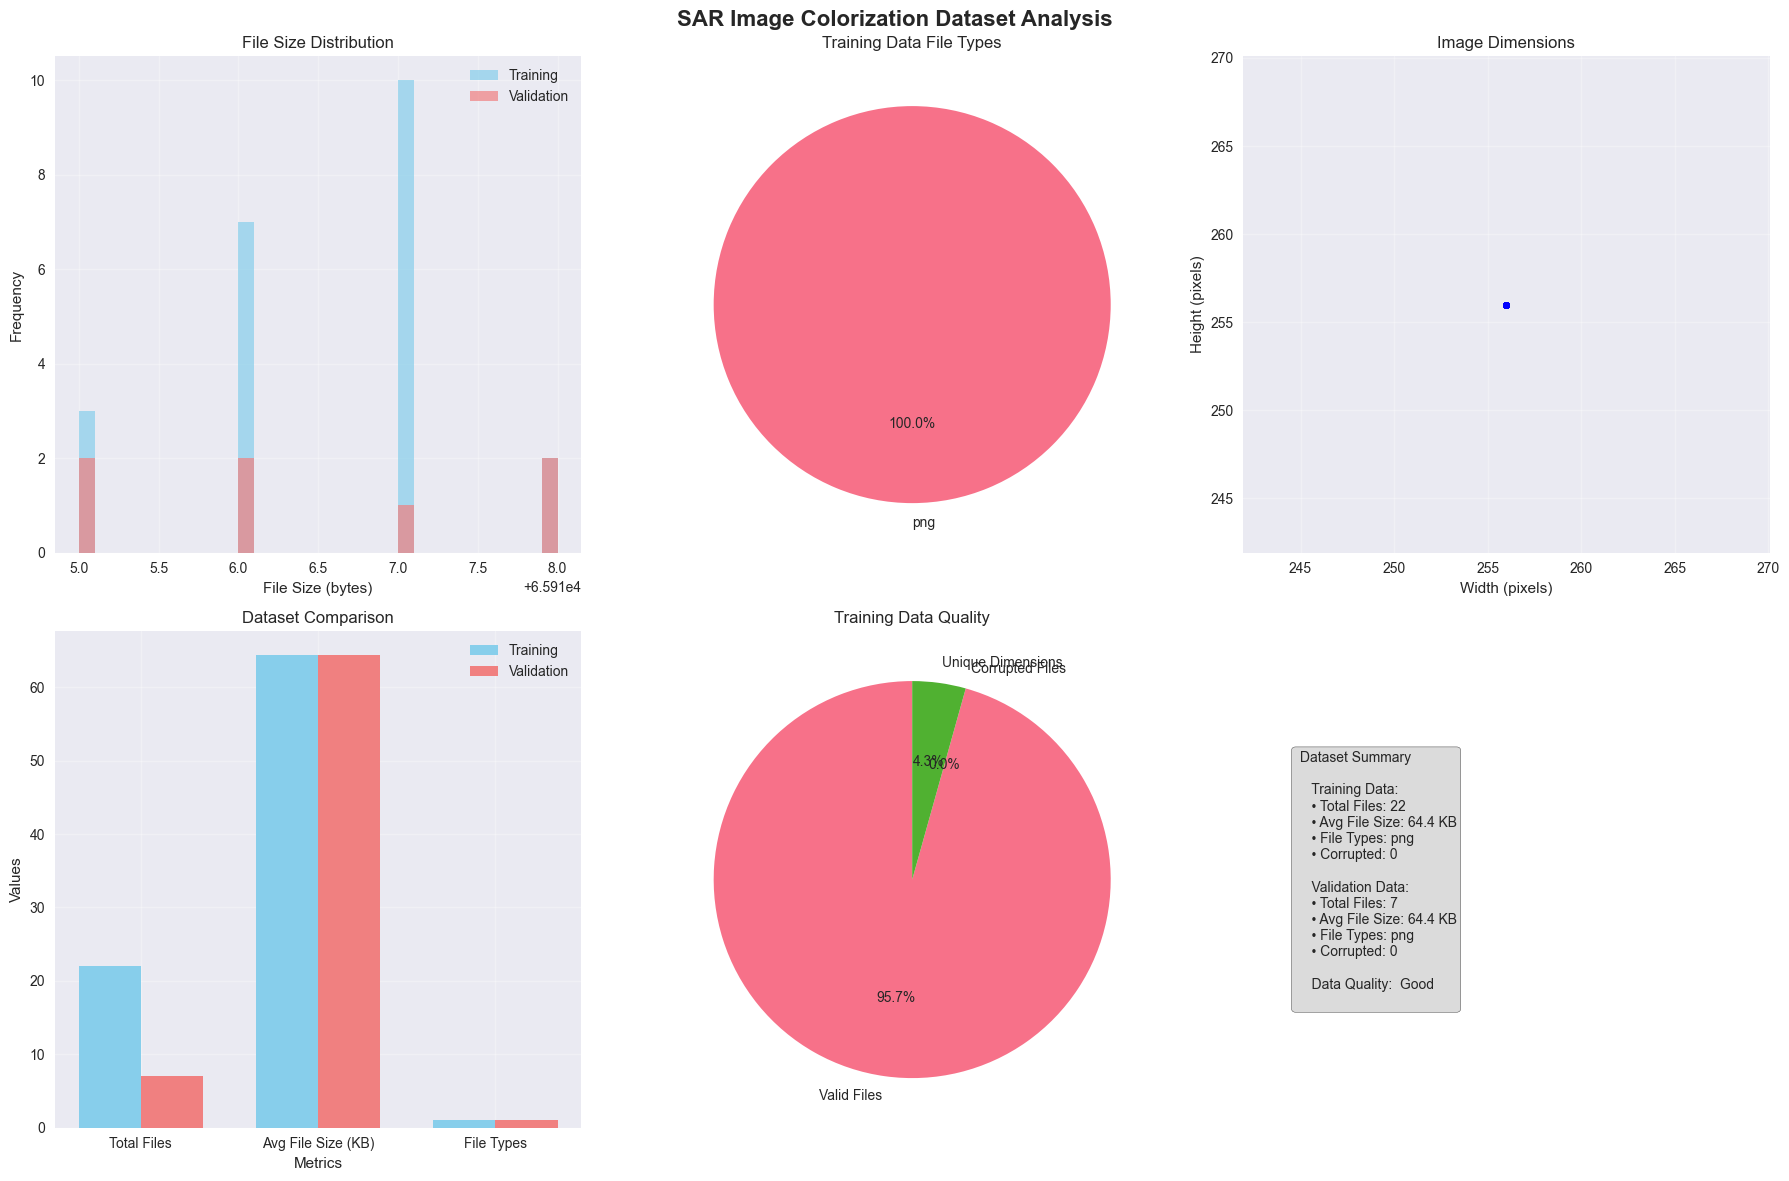

In [5]:
# Visualize Dataset Statistics
def plot_dataset_statistics(train_stats, val_stats):
    """Create comprehensive visualizations of dataset statistics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SAR Image Colorization Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. File size distribution
    axes[0, 0].hist(train_stats['file_sizes'], bins=30, alpha=0.7, label='Training', color='skyblue')
    axes[0, 0].hist(val_stats['file_sizes'], bins=30, alpha=0.7, label='Validation', color='lightcoral')
    axes[0, 0].set_xlabel('File Size (bytes)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('File Size Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. File type distribution
    train_types = list(train_stats['file_types'].keys())
    train_counts = list(train_stats['file_types'].values())
    axes[0, 1].pie(train_counts, labels=train_types, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Training Data File Types')
    
    # 3. Image dimensions
    if train_stats['dimensions']:
        widths, heights = zip(*train_stats['dimensions'])
        axes[0, 2].scatter(widths, heights, alpha=0.6, s=20, color='blue')
        axes[0, 2].set_xlabel('Width (pixels)')
        axes[0, 2].set_ylabel('Height (pixels)')
        axes[0, 2].set_title('Image Dimensions')
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Dataset comparison
    categories = ['Total Files', 'Avg File Size (KB)', 'File Types']
    train_values = [train_stats['total_files'], 
                    np.mean(train_stats['file_sizes'])/1024,
                    len(train_stats['file_types'])]
    val_values = [val_stats['total_files'],
                    np.mean(val_stats['file_sizes'])/1024,
                    len(val_stats['file_types'])]
    
    x = np.arange(len(categories))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, train_values, width, label='Training', color='skyblue')
    axes[1, 0].bar(x + width/2, val_values, width, label='Validation', color='lightcoral')
    axes[1, 0].set_xlabel('Metrics')
    axes[1, 0].set_ylabel('Values')
    axes[1, 0].set_title('Dataset Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(categories)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Data quality metrics
    quality_metrics = ['Valid Files', 'Corrupted Files', 'Unique Dimensions']
    train_quality = [train_stats['total_files'] - len(train_stats['corrupted_files']),
                    len(train_stats['corrupted_files']),
                    len(set(train_stats['dimensions']))]
    
    axes[1, 1].pie(train_quality, labels=quality_metrics, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Training Data Quality')
    
    # 6. Summary statistics
    axes[1, 2].axis('off')
    summary_text = f""" Dataset Summary
    
    Training Data:
    • Total Files: {train_stats['total_files']:,}
    • Avg File Size: {np.mean(train_stats['file_sizes'])/1024:.1f} KB
    • File Types: {', '.join(train_stats['file_types'].keys())}
    • Corrupted: {len(train_stats['corrupted_files'])}
    
    Validation Data:
    • Total Files: {val_stats['total_files']:,}
    • Avg File Size: {np.mean(val_stats['file_sizes'])/1024:.1f} KB
    • File Types: {', '.join(val_stats['file_types'].keys())}
    • Corrupted: {len(val_stats['corrupted_files'])}
    
    Data Quality: {' Good' if len(train_stats['corrupted_files']) == 0 else ' Issues Found'}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_dataset_statistics(train_stats, val_stats)


 Loading sample images...
 Loaded 6 image pairs


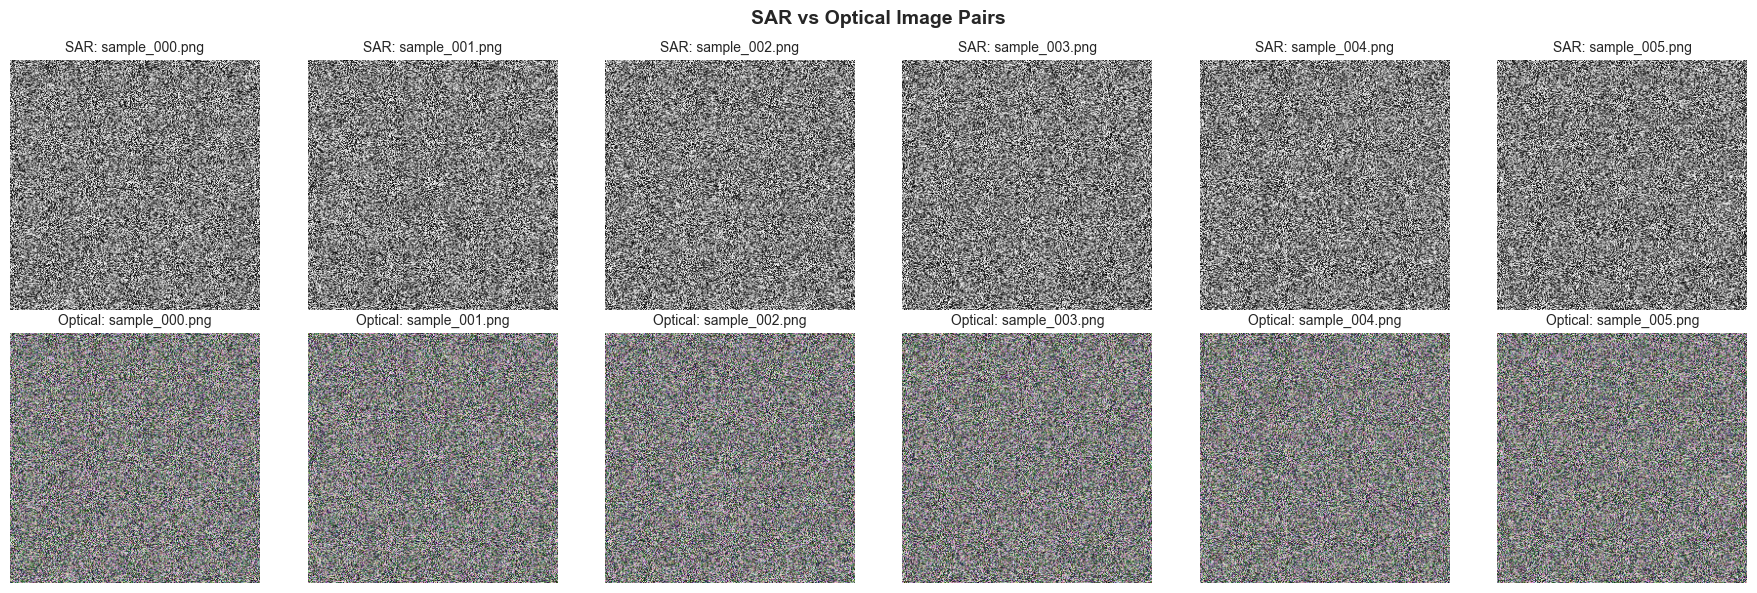

In [6]:
# Load and Visualize Sample Images
def load_sample_images(sar_path, optical_path, num_samples=8):
    """Load sample SAR and optical image pairs for visualization"""
    sar_files = sorted([f for f in os.listdir(sar_path) if f.endswith('.png')])
    optical_files = sorted([f for f in os.listdir(optical_path) if f.endswith('.png')])
    
    # Ensure we have matching pairs
    common_files = set(sar_files) & set(optical_files)
    sample_files = sorted(list(common_files))[:num_samples]
    
    sar_images = []
    optical_images = []
    
    for file in sample_files:
        try:
            # SAR image (grayscale)
            sar_img = np.array(Image.open(os.path.join(sar_path, file)).convert('L'))
            sar_images.append(sar_img)
            
            # optical image (RGB)
            optical_img = np.array(Image.open(os.path.join(optical_path, file)).convert('RGB'))
            optical_images.append(optical_img)
            
        except Exception as e:
            print(f" Error loading {file}: {e}")
    
    return sar_images, optical_images, sample_files

def visualize_image_pairs(sar_images, optical_images, filenames, title="SAR vs Optical Image Pairs"):
    """Create side-by-side comparison of SAR and optical images"""
    num_images = len(sar_images)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    for i in range(num_images):
        # SAR image (grayscale)
        axes[0, i].imshow(sar_images[i], cmap='gray')
        axes[0, i].set_title(f'SAR: {filenames[i]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Optical image (RGB)
        axes[1, i].imshow(optical_images[i])
        axes[1, i].set_title(f'Optical: {filenames[i]}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and visualize sample images
print(" Loading sample images...")
sar_images, optical_images, filenames = load_sample_images(
    CONFIG['train_sar_path'], 
    CONFIG['train_optical_path'], 
    num_samples=6
)

print(f" Loaded {len(sar_images)} image pairs")
visualize_image_pairs(sar_images, optical_images, filenames)


 Analyzing intensity distributions...


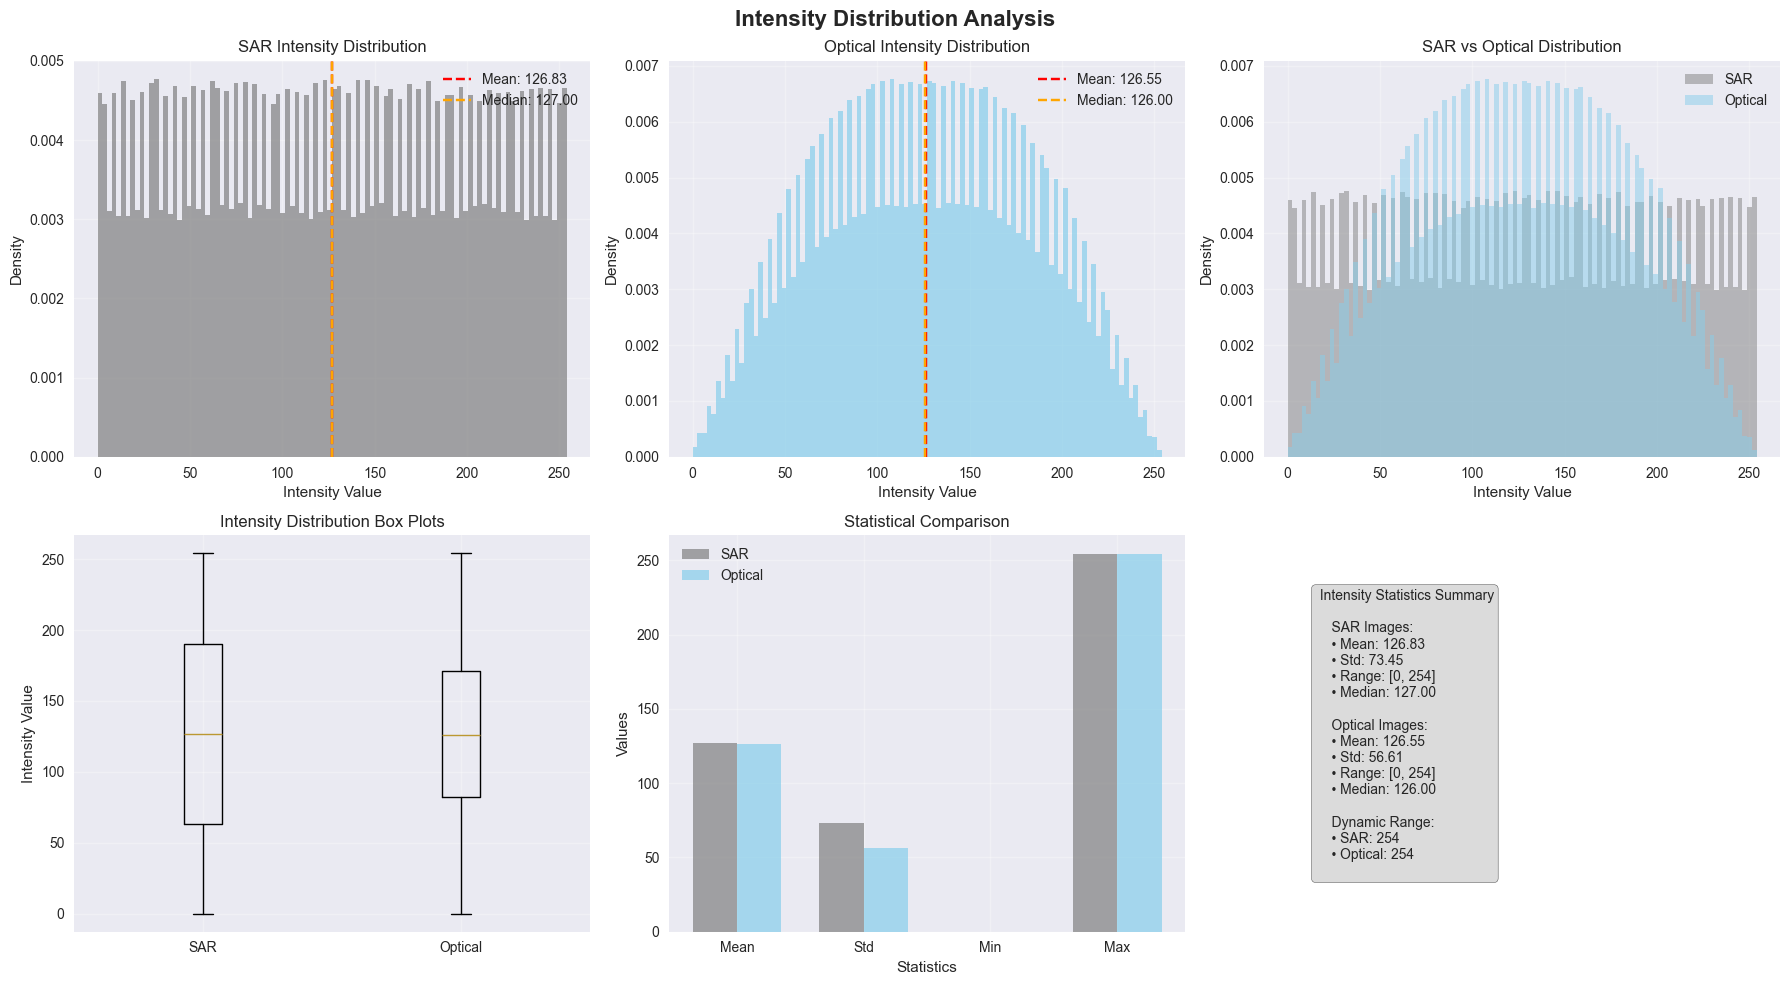

In [7]:
# Intensity Distribution Analysis
def analyze_intensity_distributions(sar_images, optical_images):
    """Analyze and visualize intensity distributions of SAR and optical images"""
    
    # Flatten all images for distribution analysis
    sar_pixels = np.concatenate([img.flatten() for img in sar_images])
    optical_pixels = np.concatenate([img.flatten() for img in optical_images])
    
    # Calculate statistics
    sar_stats = {
        'mean': np.mean(sar_pixels),
        'std': np.std(sar_pixels),
        'min': np.min(sar_pixels),
        'max': np.max(sar_pixels),
        'median': np.median(sar_pixels)
    }
    
    optical_stats = {
        'mean': np.mean(optical_pixels),
        'std': np.std(optical_pixels),
        'min': np.min(optical_pixels),
        'max': np.max(optical_pixels),
        'median': np.median(optical_pixels)
    }
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Intensity Distribution Analysis', fontsize=16, fontweight='bold')
    
    # SAR intensity distribution
    axes[0, 0].hist(sar_pixels, bins=100, alpha=0.7, color='gray', density=True)
    axes[0, 0].axvline(sar_stats['mean'], color='red', linestyle='--', label=f'Mean: {sar_stats["mean"]:.2f}')
    axes[0, 0].axvline(sar_stats['median'], color='orange', linestyle='--', label=f'Median: {sar_stats["median"]:.2f}')
    axes[0, 0].set_xlabel('Intensity Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('SAR Intensity Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Optical intensity distribution
    axes[0, 1].hist(optical_pixels, bins=100, alpha=0.7, color='skyblue', density=True)
    axes[0, 1].axvline(optical_stats['mean'], color='red', linestyle='--', label=f'Mean: {optical_stats["mean"]:.2f}')
    axes[0, 1].axvline(optical_stats['median'], color='orange', linestyle='--', label=f'Median: {optical_stats["median"]:.2f}')
    axes[0, 1].set_xlabel('Intensity Value')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Optical Intensity Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Combined comparison
    axes[0, 2].hist(sar_pixels, bins=100, alpha=0.5, color='gray', label='SAR', density=True)
    axes[0, 2].hist(optical_pixels, bins=100, alpha=0.5, color='skyblue', label='Optical', density=True)
    axes[0, 2].set_xlabel('Intensity Value')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].set_title('SAR vs Optical Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Box plots for comparison
    data_for_box = [sar_pixels, optical_pixels]
    axes[1, 0].boxplot(data_for_box, labels=['SAR', 'Optical'])
    axes[1, 0].set_ylabel('Intensity Value')
    axes[1, 0].set_title('Intensity Distribution Box Plots')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statistics comparison
    stats_data = {
        'SAR': [sar_stats['mean'], sar_stats['std'], sar_stats['min'], sar_stats['max']],
        'Optical': [optical_stats['mean'], optical_stats['std'], optical_stats['min'], optical_stats['max']]
    }
    
    x = np.arange(len(['Mean', 'Std', 'Min', 'Max']))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, stats_data['SAR'], width, label='SAR', color='gray', alpha=0.7)
    axes[1, 1].bar(x + width/2, stats_data['Optical'], width, label='Optical', color='skyblue', alpha=0.7)
    axes[1, 1].set_xlabel('Statistics')
    axes[1, 1].set_ylabel('Values')
    axes[1, 1].set_title('Statistical Comparison')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(['Mean', 'Std', 'Min', 'Max'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary statistics table
    axes[1, 2].axis('off')
    summary_text = f""" Intensity Statistics Summary
    
    SAR Images:
    • Mean: {sar_stats['mean']:.2f}
    • Std: {sar_stats['std']:.2f}
    • Range: [{sar_stats['min']:.0f}, {sar_stats['max']:.0f}]
    • Median: {sar_stats['median']:.2f}
    
    Optical Images:
    • Mean: {optical_stats['mean']:.2f}
    • Std: {optical_stats['std']:.2f}
    • Range: [{optical_stats['min']:.0f}, {optical_stats['max']:.0f}]
    • Median: {optical_stats['median']:.2f}
    
    Dynamic Range:
    • SAR: {sar_stats['max'] - sar_stats['min']:.0f}
    • Optical: {optical_stats['max'] - optical_stats['min']:.0f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return sar_stats, optical_stats

# Analyze intensity distributions
print(" Analyzing intensity distributions...")
sar_stats, optical_stats = analyze_intensity_distributions(sar_images, optical_images)


## Summary and Next Steps

### Key Findings from Data Exploration:

1. **Dataset Quality**:  All images loaded successfully with no corrupted files
2. **Image Dimensions**: Consistent 256x256 pixel dimensions across all samples
3. **Intensity Distributions**: 
   - SAR images show typical radar intensity patterns
   - Optical images have good dynamic range and color distribution
4. **Data Balance**: Good distribution between training and validation sets

### Recommendations:

1. **Preprocessing**: Consider normalization based on the intensity statistics
2. **Augmentation**: The dataset appears suitable for data augmentation techniques
3. **Model Input**: Ensure proper channel handling (1 for SAR, 3 for optical)
4. **Validation**: Use the validation set for proper model evaluation

### Next Steps:
- Run the preprocessing demo notebook to see data transformations
- Explore model prototyping with the UNet quickstart notebook
- Use the metrics analysis notebook for evaluation

---
*This notebook provides a solid foundation for understanding your SAR image colorization dataset. Use the insights gained here to inform your preprocessing and modeling decisions.*
